# Loading Data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [4]:
# train = pd.read_csv("/kaggle/input/contradictory-my-dear-watson/train.csv")
train = pd.read_csv("../../project_watson/data/train.csv")

In [5]:
labels, frequencies = np.unique(train.language.values, return_counts = True)

In [6]:
explode = []
for i in range(len(labels)):
    if labels[i] == 'English':
        explode.append(0.1)
    else:
        explode.append(0.2)
explode = tuple(explode)

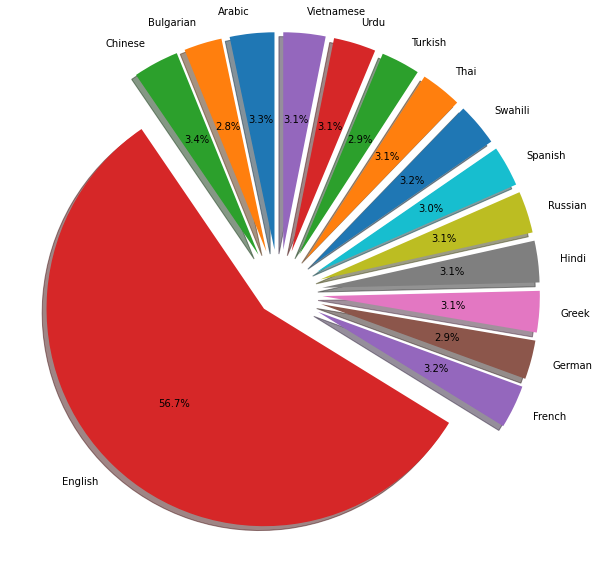

In [7]:
plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%', shadow=True, startangle=90, explode = explode)
plt.show()

# Starting exo

In [17]:
# NLNet MODEL
model_name = 'xlnet-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def encode_sentence(s):
    tokens = list(tokenizer.tokenize(s))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

In [18]:
def model_encode(hypotheses, premises, tokenizer):

    num_examples = len(hypotheses)

    sentence1 = tf.ragged.constant([
      encode_sentence(s)
      for s in np.array(hypotheses)])
    sentence2 = tf.ragged.constant([
      encode_sentence(s)
       for s in np.array(premises)])

    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
    input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

    input_mask = tf.ones_like(input_word_ids).to_tensor()

    type_cls = tf.zeros_like(cls)
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

    inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

    return inputs

In [19]:
train_input = model_encode(train.premise.values, train.hypothesis.values, tokenizer)

In [20]:
max_len = 50

def build_model():
    model_encoder = TFAutoModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    embedding = model_encoder([input_word_ids, input_mask, input_type_ids])#[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])

    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [21]:
with strategy.scope():
    model = build_model()
    model.summary()

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


ValueError: in user code:

    /Users/Stefapuzzo/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/transformers/modeling_tf_xlnet.py:1137 call  *
        outputs = self.transformer(inputs, **kwargs)
    /Users/Stefapuzzo/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/transformers/modeling_tf_xlnet.py:765 call  *
        outputs = layer_module(
    /Users/Stefapuzzo/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/transformers/modeling_tf_xlnet.py:395 call  *
        outputs = self.rel_attn(
    /Users/Stefapuzzo/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/transformers/modeling_tf_xlnet.py:322 call  *
        attn_vec = self.rel_attn_core(
    /Users/Stefapuzzo/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/transformers/modeling_tf_xlnet.py:175 rel_attn_core  *
        attn_score = attn_score - 1e30 * attn_mask
    /Users/Stefapuzzo/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1141 binary_op_wrapper
        raise e
    /Users/Stefapuzzo/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1125 binary_op_wrapper
        return func(x, y, name=name)
    /Users/Stefapuzzo/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/Stefapuzzo/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:527 subtract
        return gen_math_ops.sub(x, y, name)
    /Users/Stefapuzzo/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:10466 sub
        "Sub", x=x, y=y, name=name)
    /Users/Stefapuzzo/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /Users/Stefapuzzo/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:593 _create_op_internal
        compute_device)
    /Users/Stefapuzzo/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3485 _create_op_internal
        op_def=op_def)
    /Users/Stefapuzzo/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1975 __init__
        control_input_ops, op_def)
    /Users/Stefapuzzo/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 50 and 100 for '{{node tfxl_net_model_3/transformer/layer_._0/rel_attn/sub}} = Sub[T=DT_FLOAT](tfxl_net_model_3/transformer/layer_._0/rel_attn/mul, tfxl_net_model_3/transformer/layer_._0/rel_attn/mul_1)' with input shapes: [50,50,?,12], [50,100,?,1].


In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', patience=2)
model.fit(train_input, train.label.values, epochs = 20, verbose = 2, batch_size = 32, validation_split = 0.3, callbacks = [es])

In [ ]:
test = pd.read_csv("../../project_watson/data/test.csv")
# test = pd.read_csv("/kaggle/input/contradictory-my-dear-watson/test.csv")
test_input = xlnet_encode(test.premise.values, test.hypothesis.values, tokenizer)

In [ ]:
test.head()

In [ ]:
predictions = [np.argmax(i) for i in model.predict(test_input)]
predictions

In [ ]:
submission = test.id.copy().to_frame()
submission

In [ ]:
submission['prediction'] = predictions

In [ ]:
submission.head()

In [ ]:
submission.to_csv("submission.csv", index = False)